<a href="https://colab.research.google.com/github/lyuoveta/ABD/blob/main/final_project_INNO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Описание набора данных**

В этом проекте используется набор данных IMDB, который состоит из 50 000 отзывов на фильмы с известного сайта о кино imdb. Каждый отзыв содержит метку позитивный или негативный.



review - текст отзыва на английском языке

sentiment - positive/negative

# **Загрузка и предварительная обработка данных**

In [1]:
# Импорт и установка библиотек

In [2]:
!pip install -q -U watermark
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.25.2
pandas      : 2.0.3
torch       : 2.2.1+cu121
transformers: 4.40.0



In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize, pos_tag

In [6]:
# Настройка визуализации и окружения

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
# Загрузка данных

In [9]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
# Сруктура и характеристики датафрейма

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [12]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [13]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [14]:
df['review'].duplicated().sum()

418

In [15]:
# Удаление дубликатов

df.drop_duplicates(subset=['review'], keep='first', inplace=True)

In [16]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

Датафрейм после обработки не содежит пропущенных значений, дубликатов

In [17]:
#Предварительная обработка текста

In [18]:
nltk.download('stopwords')

# Удаление стоп-слов
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Удаление знаков пунктуации
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Нормализация (приводит все к нижнему регистру, удаляет лишние пробелы, URLы и несловесные символы)
def normalize_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

# Стемминг текста, приводя слова к их корневым формам
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Комплексная функция очистки текста
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
df['review'] = df['review'].apply(clean_text)

In [20]:
# кодирование текстовых меток в числовые: 'positive' - 1, 'negative' - 0

def to_sentiment(rating):
    if rating == 'positive':
        return 1
    else:
        return 0

df['sentiment'] = df['sentiment'].apply(to_sentiment)

In [21]:
df.head()

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,1
1,wonder littl product br br film techniqu unass...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


In [22]:
class_names = ['negative', 'positive']

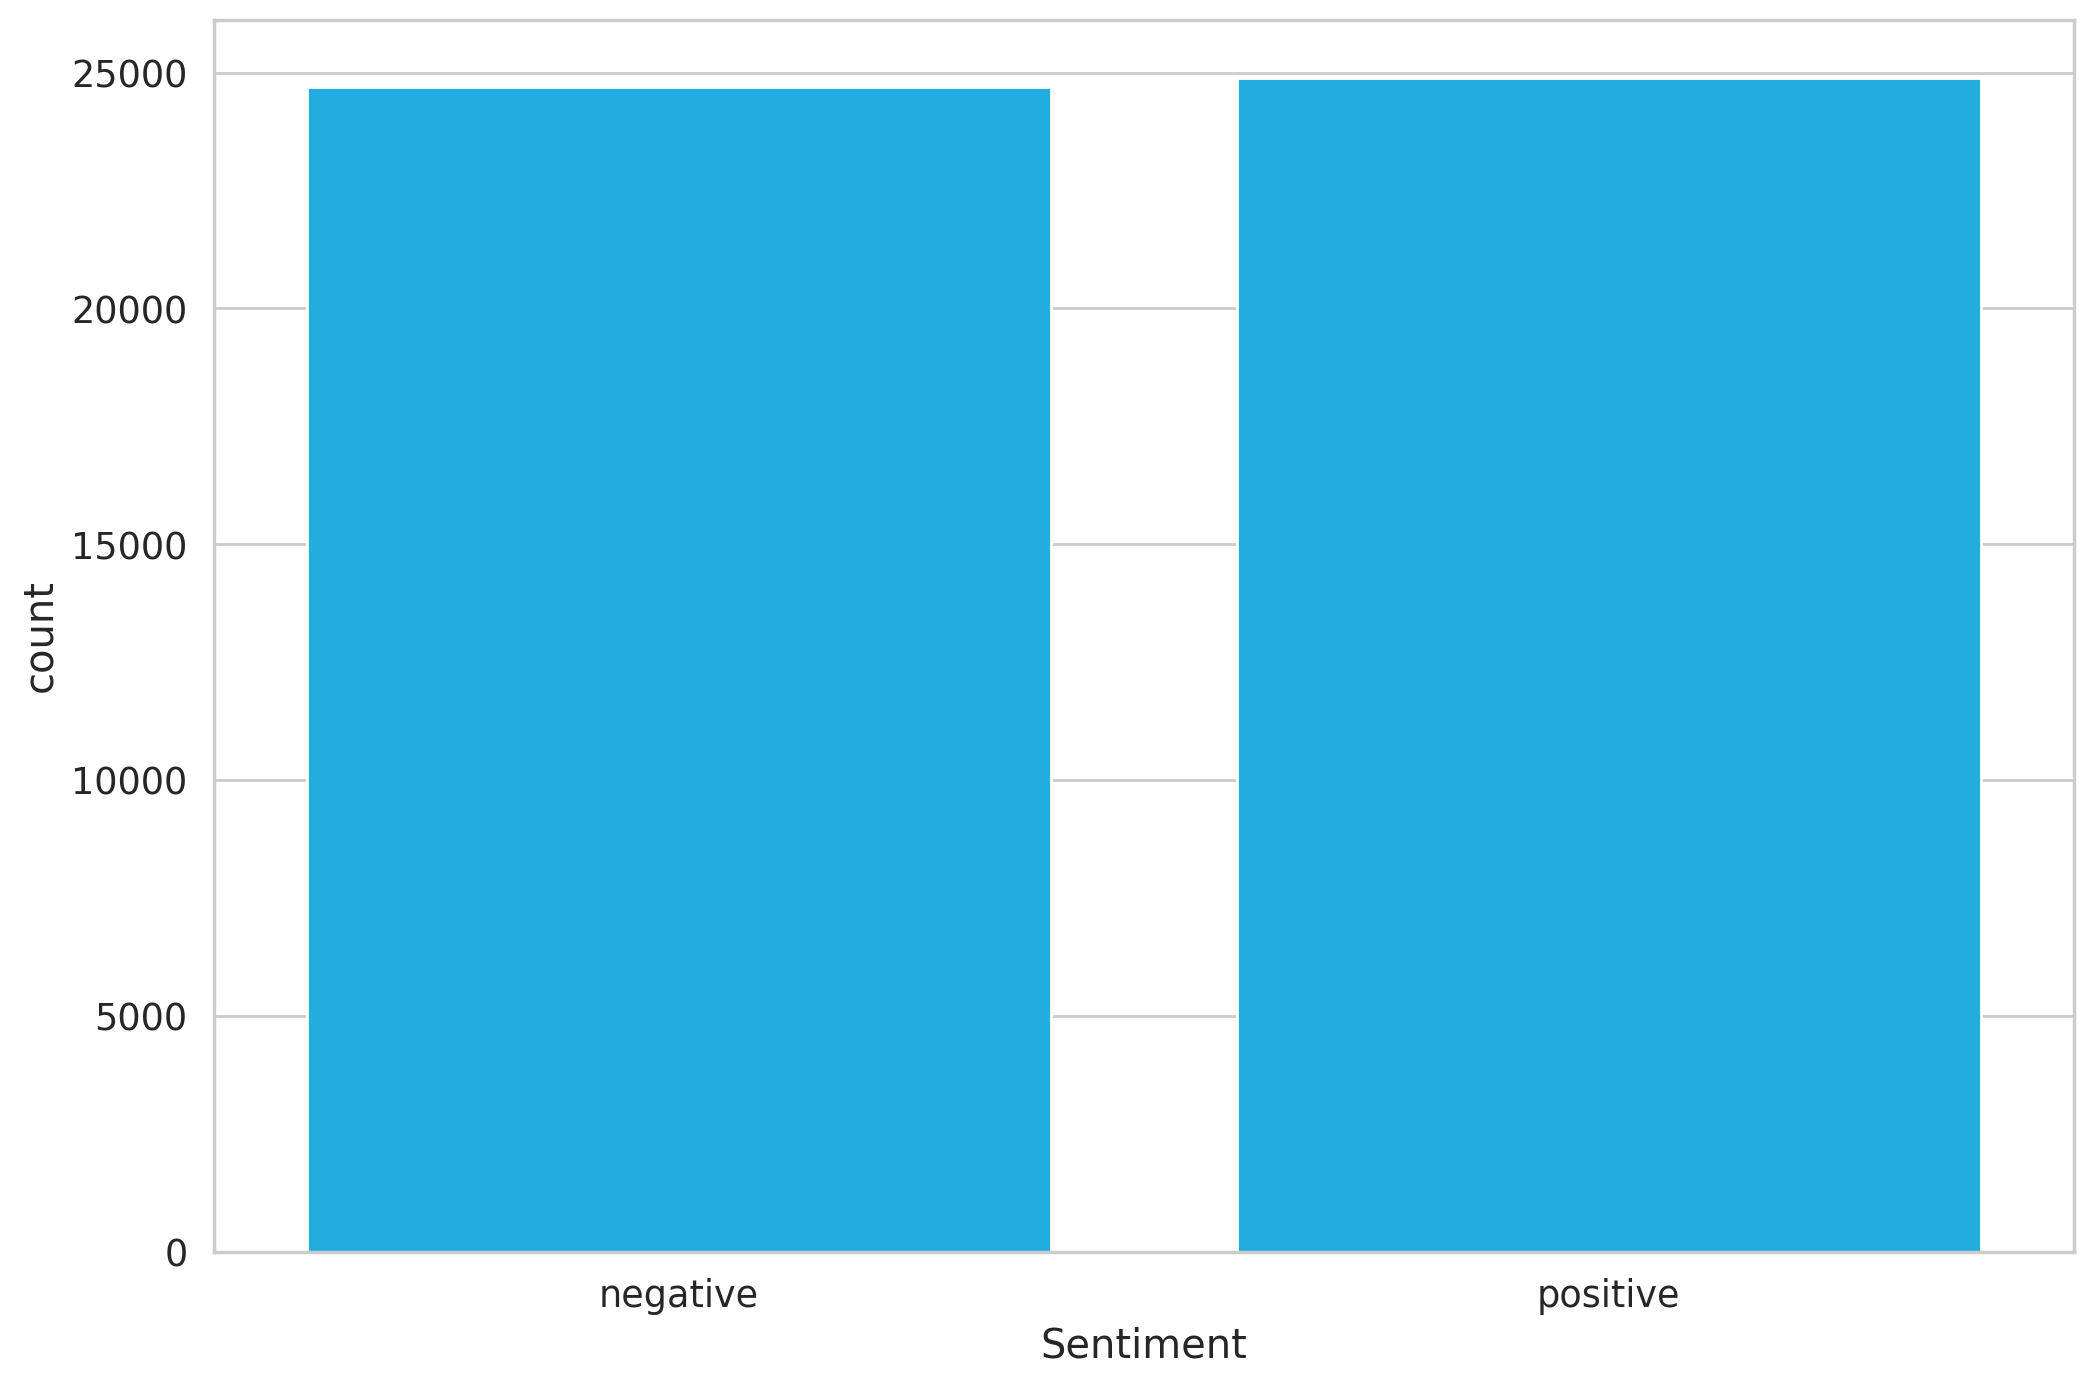

In [23]:
ax = sns.countplot(x='sentiment', data=df)

ax.set_xticks([0, 1])
ax.set_xticklabels(['negative', 'positive'])

plt.xlabel('Sentiment')
plt.show()

 Нет дисбаланса классов. Следовательно, можно использовать точность в качестве показателя.



# **Постановка задачи и построение модели**

Задача состоит в том, чтобы разработать модель машинного обучения, которая сможет анализировать тексты отзывов на фильмы и предсказывать их эмоциональную окраску. Ключевым аспектом здесь является различение положительных и негативных отзывов.

Для классификации эмоциональной окраски рецензий на фильмы используется модель BERT.

In [24]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [25]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
# Вывод специальных токенов, используемых моделью BERT и их ID

tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

- SEP — Маркер окончания предложения. BERT использует число 102 для этого маркера.

- CLS — Токен, который нужно добавлять в начале каждого предложения, чтобы BERT понимал, что выполняется задача классификации. Для этого токена BERT использует число 101.
- PAD — Специальный токен для заполнения текстовых данных до определенной длины. BERT использует число 0 для этого токена.

- UNK — Токен для обозначения неизвестных слов, которые не встречались в обучающем наборе данных.

In [27]:
# Пример перевода токенов
sample_txt = 'hello'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[19082]

In [28]:
MAX_LEN = 512

In [29]:
# Кодируем текст, добавляя специальные токены

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [30]:
# Преобразование ID обратно в токены для проверки

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'hello',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',


In [31]:
# Анализ длины токенов

token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-32-599e5513a981>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


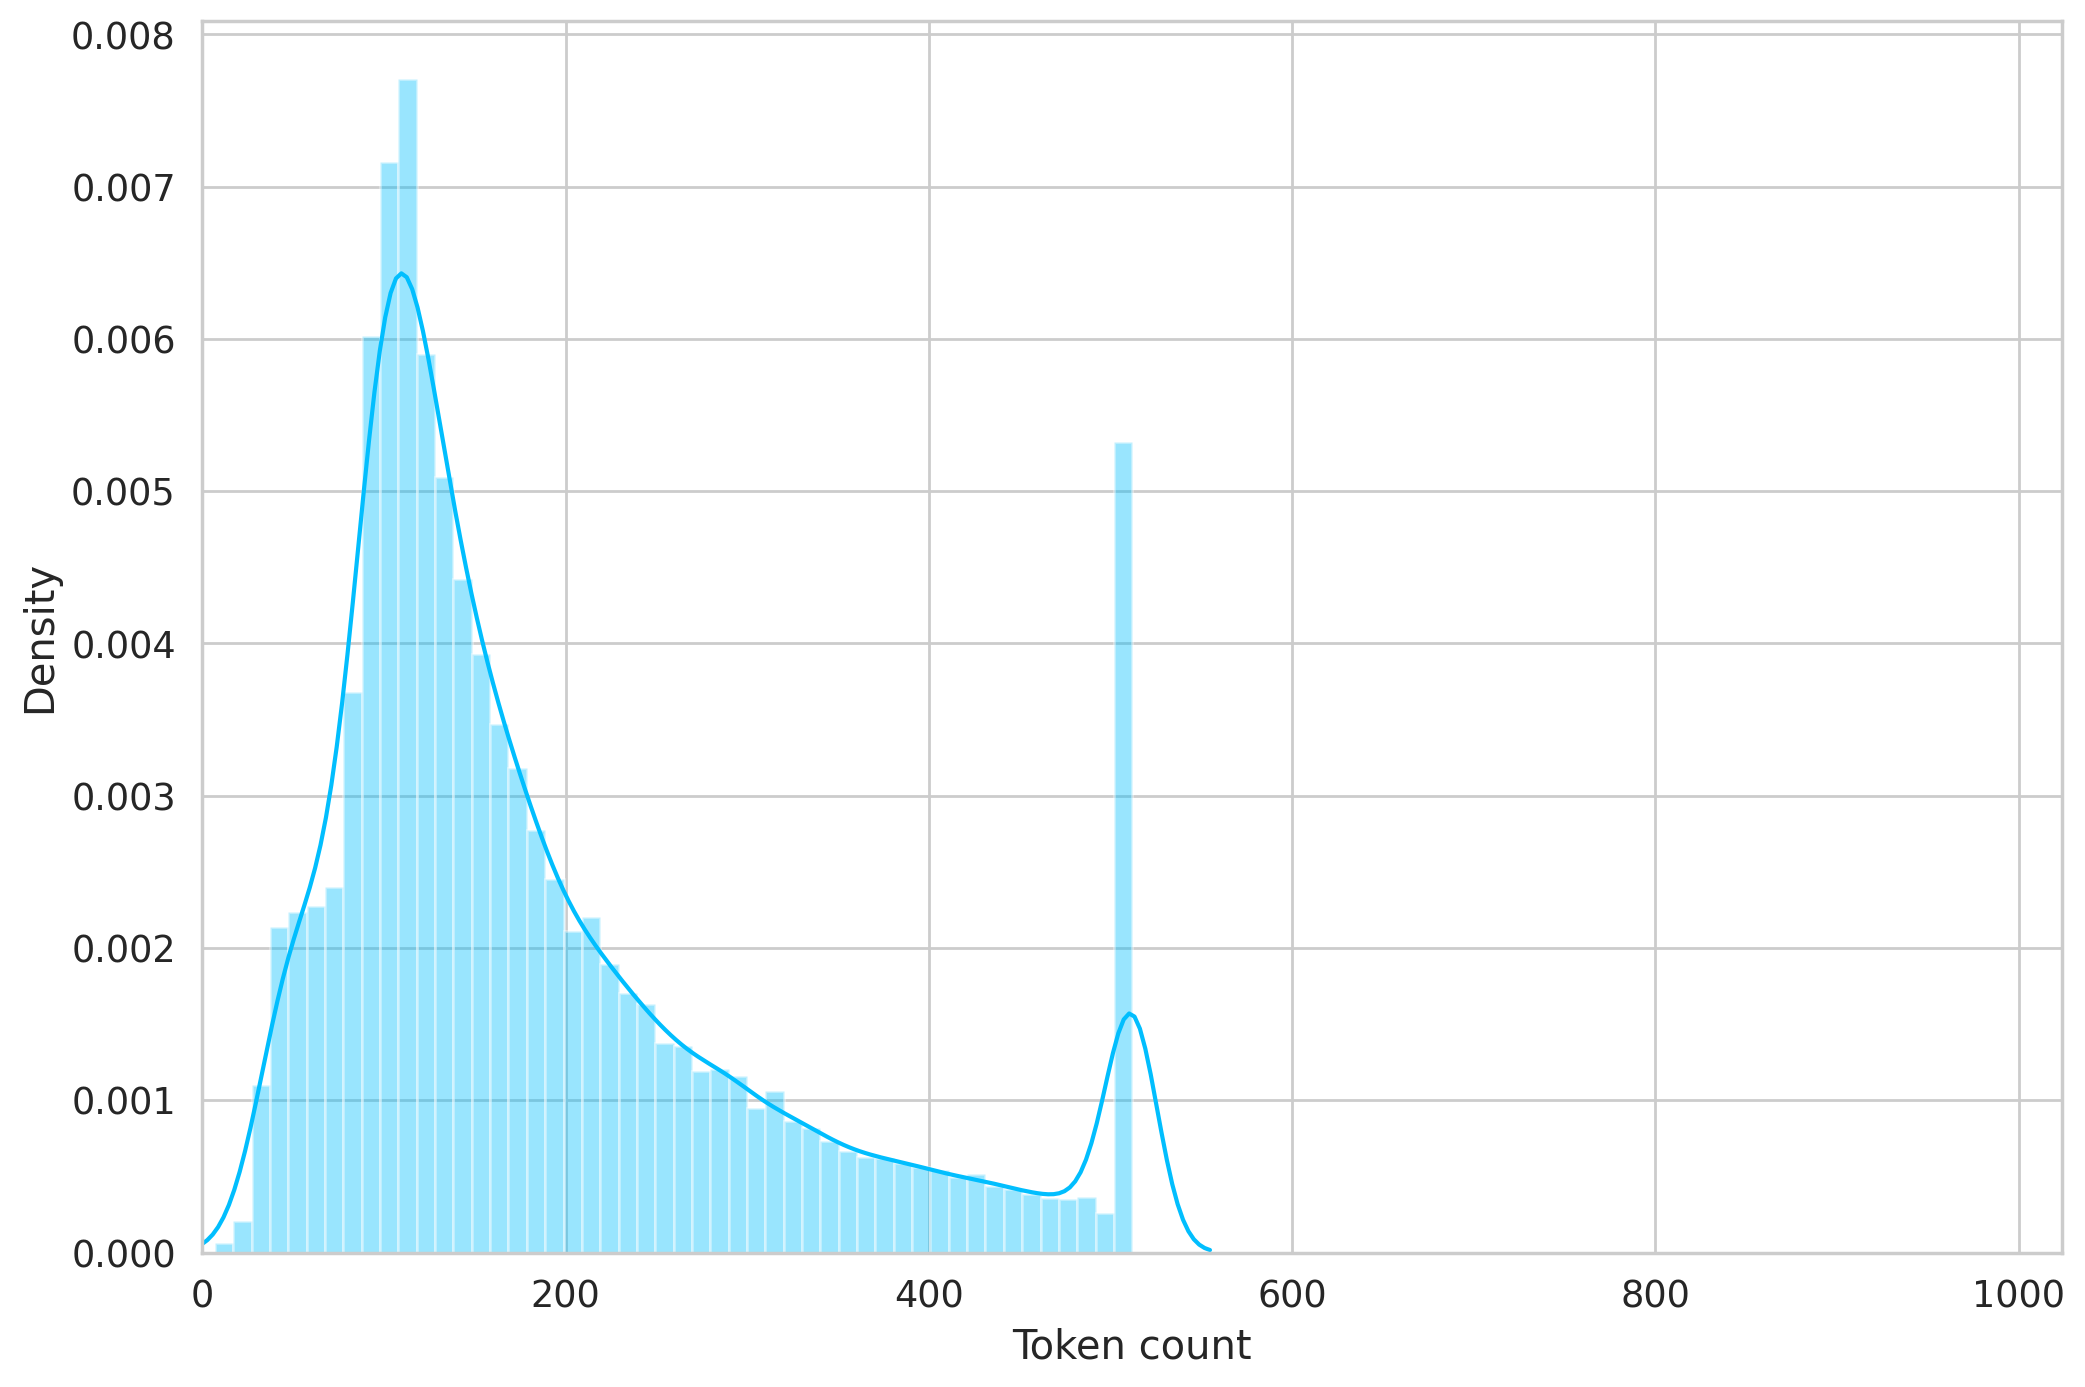

In [32]:
# Визуализация распределения длины токенов

sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

Большинство отзывов содержат количество токенов меньше 512, ограничимся этой размерностью.

In [33]:
MAX_LEN = 512

In [34]:
# Подготовка датасета

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
# Разделение данных для обучения и тестирования

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [36]:
df_train.shape, df_val.shape, df_test.shape

((44623, 2), (2479, 2), (2480, 2))

In [37]:
# Настройка DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [38]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [39]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [41]:
outputs = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

last_hidden_state = outputs.last_hidden_state
pooler_output = outputs.pooler_output

print("Shape of last hidden state:", last_hidden_state.shape)

print("Shape of pooler output:", pooler_output.shape)

Shape of last hidden state: torch.Size([1, 512, 768])
Shape of pooler output: torch.Size([1, 768])


In [42]:
bert_model.config.hidden_size

768

In [43]:
# Построение классификатора настроений

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

In [44]:
# Инициализация модели и получение предсказаний

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 512])
torch.Size([16, 512])


In [46]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4568, 0.5432],
        [0.3266, 0.6734],
        [0.3743, 0.6257],
        [0.4086, 0.5914],
        [0.5043, 0.4957],
        [0.5664, 0.4336],
        [0.4065, 0.5935],
        [0.3261, 0.6739],
        [0.5052, 0.4948],
        [0.4444, 0.5556],
        [0.4009, 0.5991],
        [0.6780, 0.3220],
        [0.4132, 0.5868],
        [0.3332, 0.6668],
        [0.3927, 0.6073],
        [0.5398, 0.4602]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [47]:
# Настройка оптимизатора и планировщика

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [48]:
# Тренировочный этап

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
# Оценочный этап

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:
%%time

# Запуск цикла обучения на определённое количество эпох и сохранение лучшей модели

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train loss 0.5000426861794459 accuracy 0.7677430921273783
Val   loss 0.41696852565773074 accuracy 0.7983057684550222

Epoch 2/10
----------
Train loss 0.4033962599732791 accuracy 0.8418752661183695
Val   loss 0.43623672089269083 accuracy 0.8281565147236789

Epoch 3/10
----------
Train loss 0.3615779353378494 accuracy 0.8631871456423817
Val   loss 0.35285974909220974 accuracy 0.8693021379588544

Epoch 4/10
----------
Train loss 0.30756830198068524 accuracy 0.8892947583084957
Val   loss 0.3390261854135221 accuracy 0.8737394110528439

Epoch 5/10
----------
Train loss 0.27410967739391773 accuracy 0.9062366940815275
Val   loss 0.362305930328946 accuracy 0.8789834610730133

Epoch 6/10
----------
Train loss 0.2511124404377009 accuracy 0.9216099320977972
Val   loss 0.38432082301907 accuracy 0.8793868495361032

Epoch 7/10
----------
Train loss 0.22811186436714664 accuracy 0.9334423951773749
Val   loss 0.43723482975075323 accuracy 0.8805970149253731

Epoch 8/10
----------
Train loss 0.2097952125

# **Оценка модели и результатов**

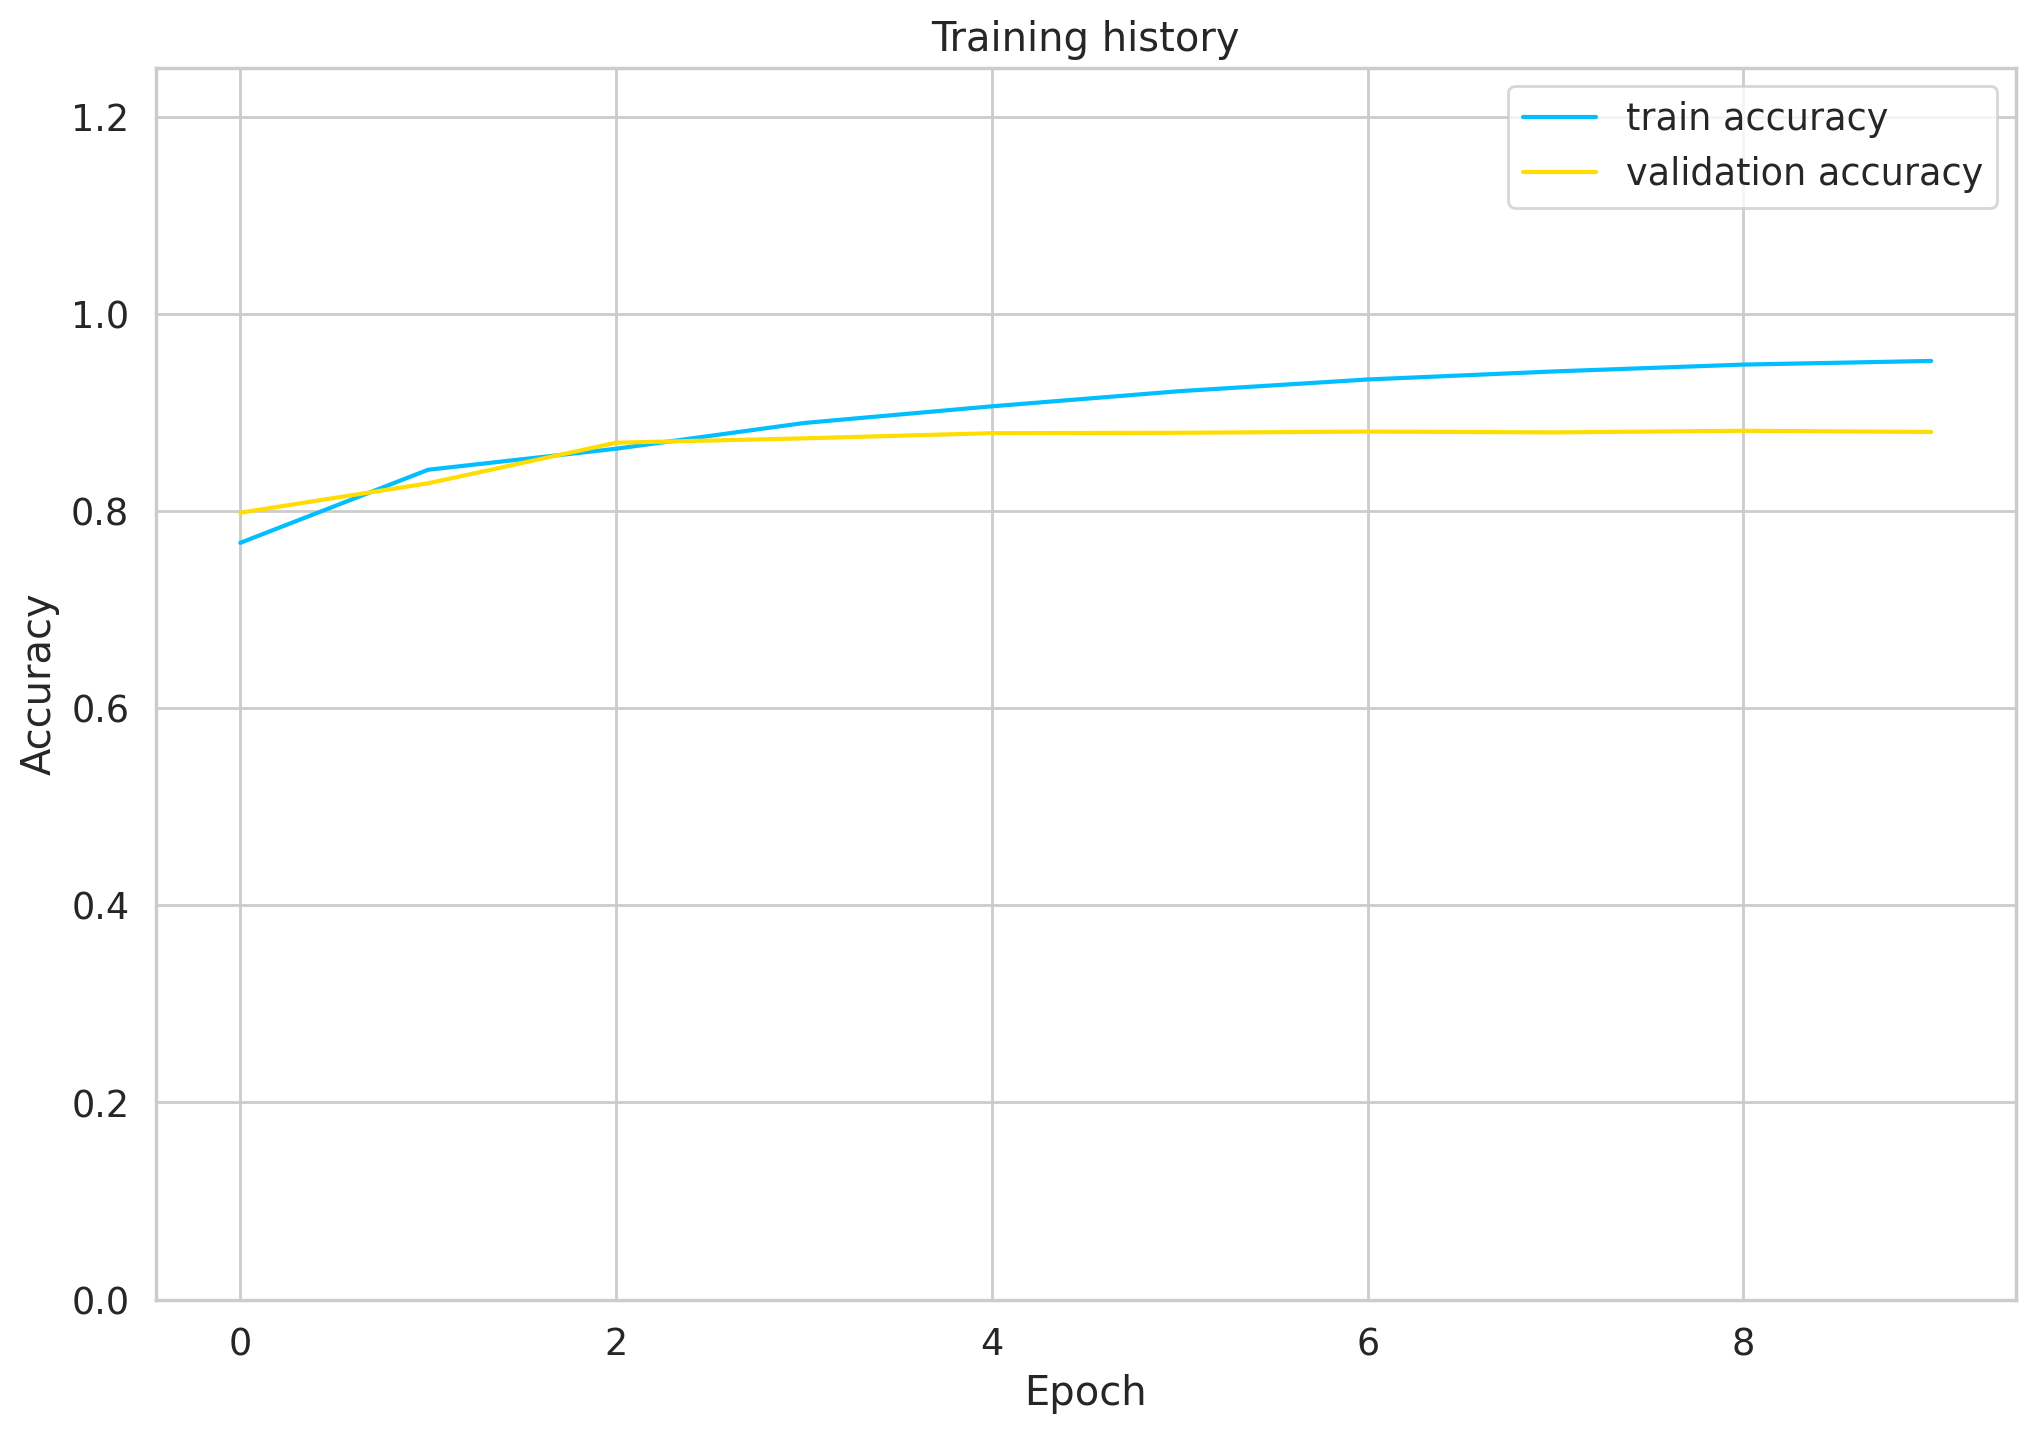

In [51]:
# Визуализация истории обучения модели

train_acc = [x.cpu().numpy() for x in history['train_acc']]
val_acc = [x.cpu().numpy() for x in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.25])
plt.show()

# Выводы:

- Эффективность обучения: Модель показывает хорошую способность к обучению и обобщению, так как разрыв между тренировочной и валидационной точностью относительно невелик.

- Отсутствие переобучения: Отсутствие значительного разрыва между кривыми тренировочной и валидационной точности указывает на то, что модель не переобучается.

- Возможность дальнейшего улучшения: Учитывая, что точность еще не достигла плато, возможно, модель может далее улучшить свою производительность с увеличением числа эпох или с иными методами оптимизации.

In [52]:
# Оценка модели на тестовом наборе данных

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8846774193548387

In [53]:
# Функция для получения предсказаний модели

def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [54]:
# Отчет классификации

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [55]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.89      0.88      1241
    positive       0.89      0.88      0.88      1239

    accuracy                           0.88      2480
   macro avg       0.88      0.88      0.88      2480
weighted avg       0.88      0.88      0.88      2480



## Выводы

1. Общая эффективность модели: Модель достигает общей точности (accuracy) 0.88, что является довольно хорошим показателем, учитывая сложность задачи анализа тональности текста.

2. Производительность по классам:
   - Класс "negative" (негативные отзывы):
     - Precision: 0.88 — это означает, что 88% отзывов, предсказанных как негативные, действительно были негативными.
     - Recall: 0.89 — это означает, что из всех истинно негативных отзывов модель смогла правильно идентифицировать 89%.
     - F1-score: 0.88 — сбалансированная мера, учитывающая и precision, и recall, равная 0.88 подтверждает сильную эффективность модели в определении негативных отзывов.

   - Класс "positive" (положительные отзывы):
     - Precision: 0.89 — 89% отзывов, классифицированных как положительные, действительно были положительными.
     - Recall: 0.88 — из всех истинно положительных отзывов модель правильно идентифицировала 88%.
     - F1-score: 0.88 — подтверждает хорошую способность модели различать положительные отзывы.

3. Сбалансированность производительности:
   - Macro avg и Weighted avg значений для precision, recall и f1-score равны 0.88, что говорит о хорошей сбалансированности модели в определении как положительных, так и негативных отзывов.

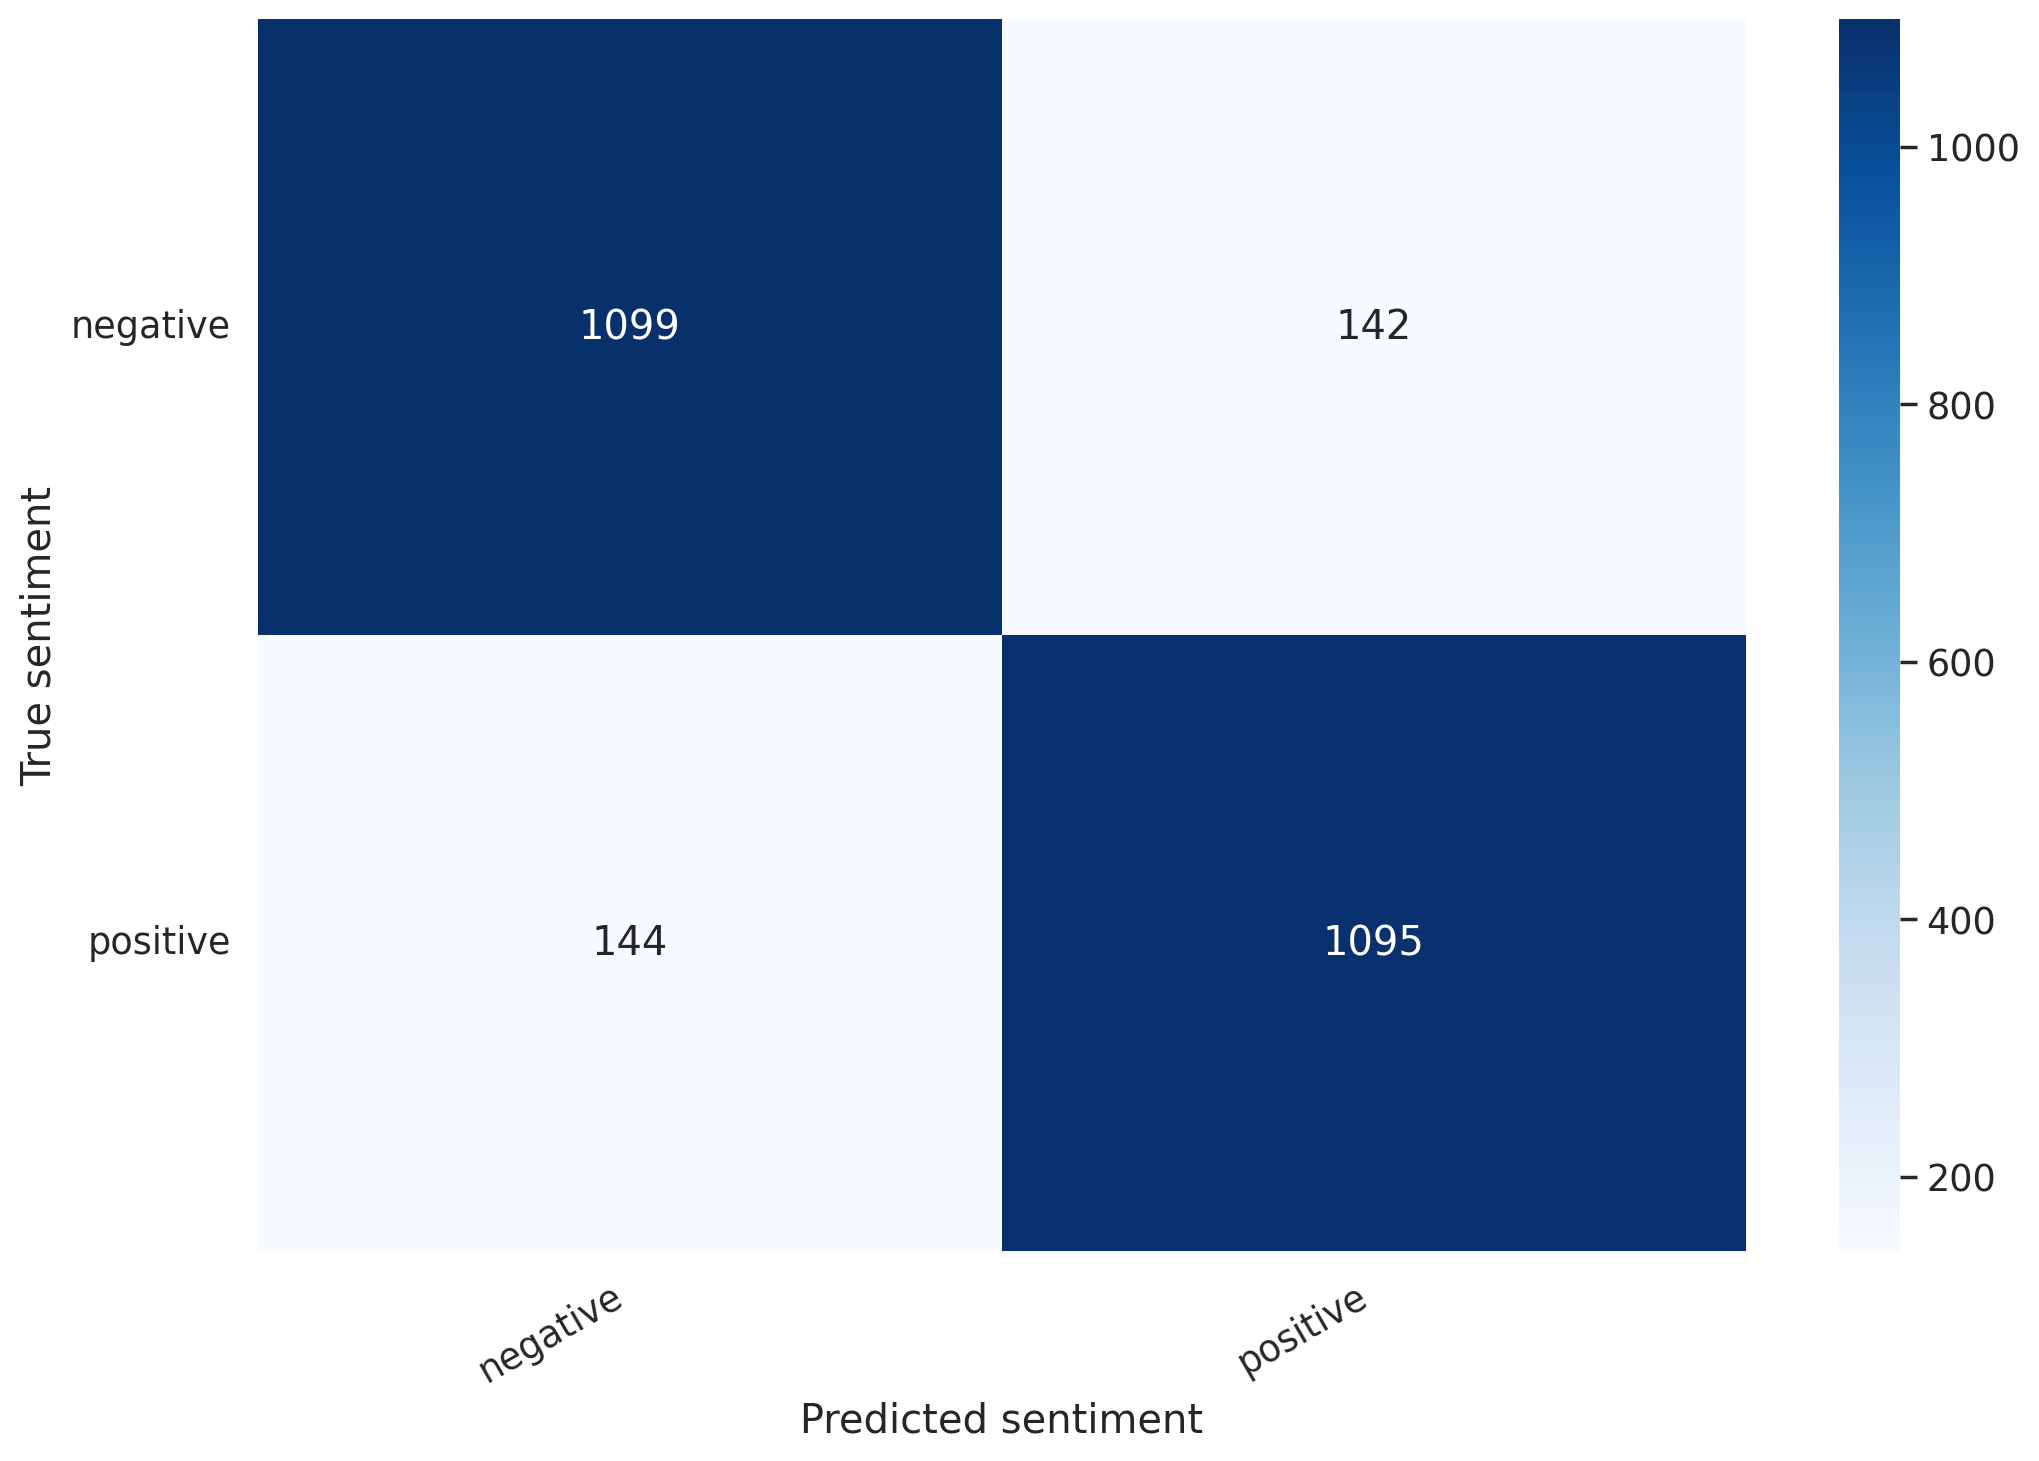

In [56]:
# Визуализация матрицы ошибок

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Выводы

1. Высокая точность: Общая точность модели довольно высока, так как большая часть прогнозов оказались правильными.

2. Сбалансированность ошибок: Количество ложноположительных (142) и ложноотрицательных (144) ошибок относительно сбалансировано, что указывает на то, что модель не имеет значительного смещения в пользу какого-либо из классов.

3. Возможные улучшения: Для улучшения модели можно сосредоточить усилия на минимизации каждого типа ошибок, применяя дополнительные техники обработки данных.


In [57]:
# Демонстрация работы модели классификации текста

idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [65]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')


True sentiment: negative


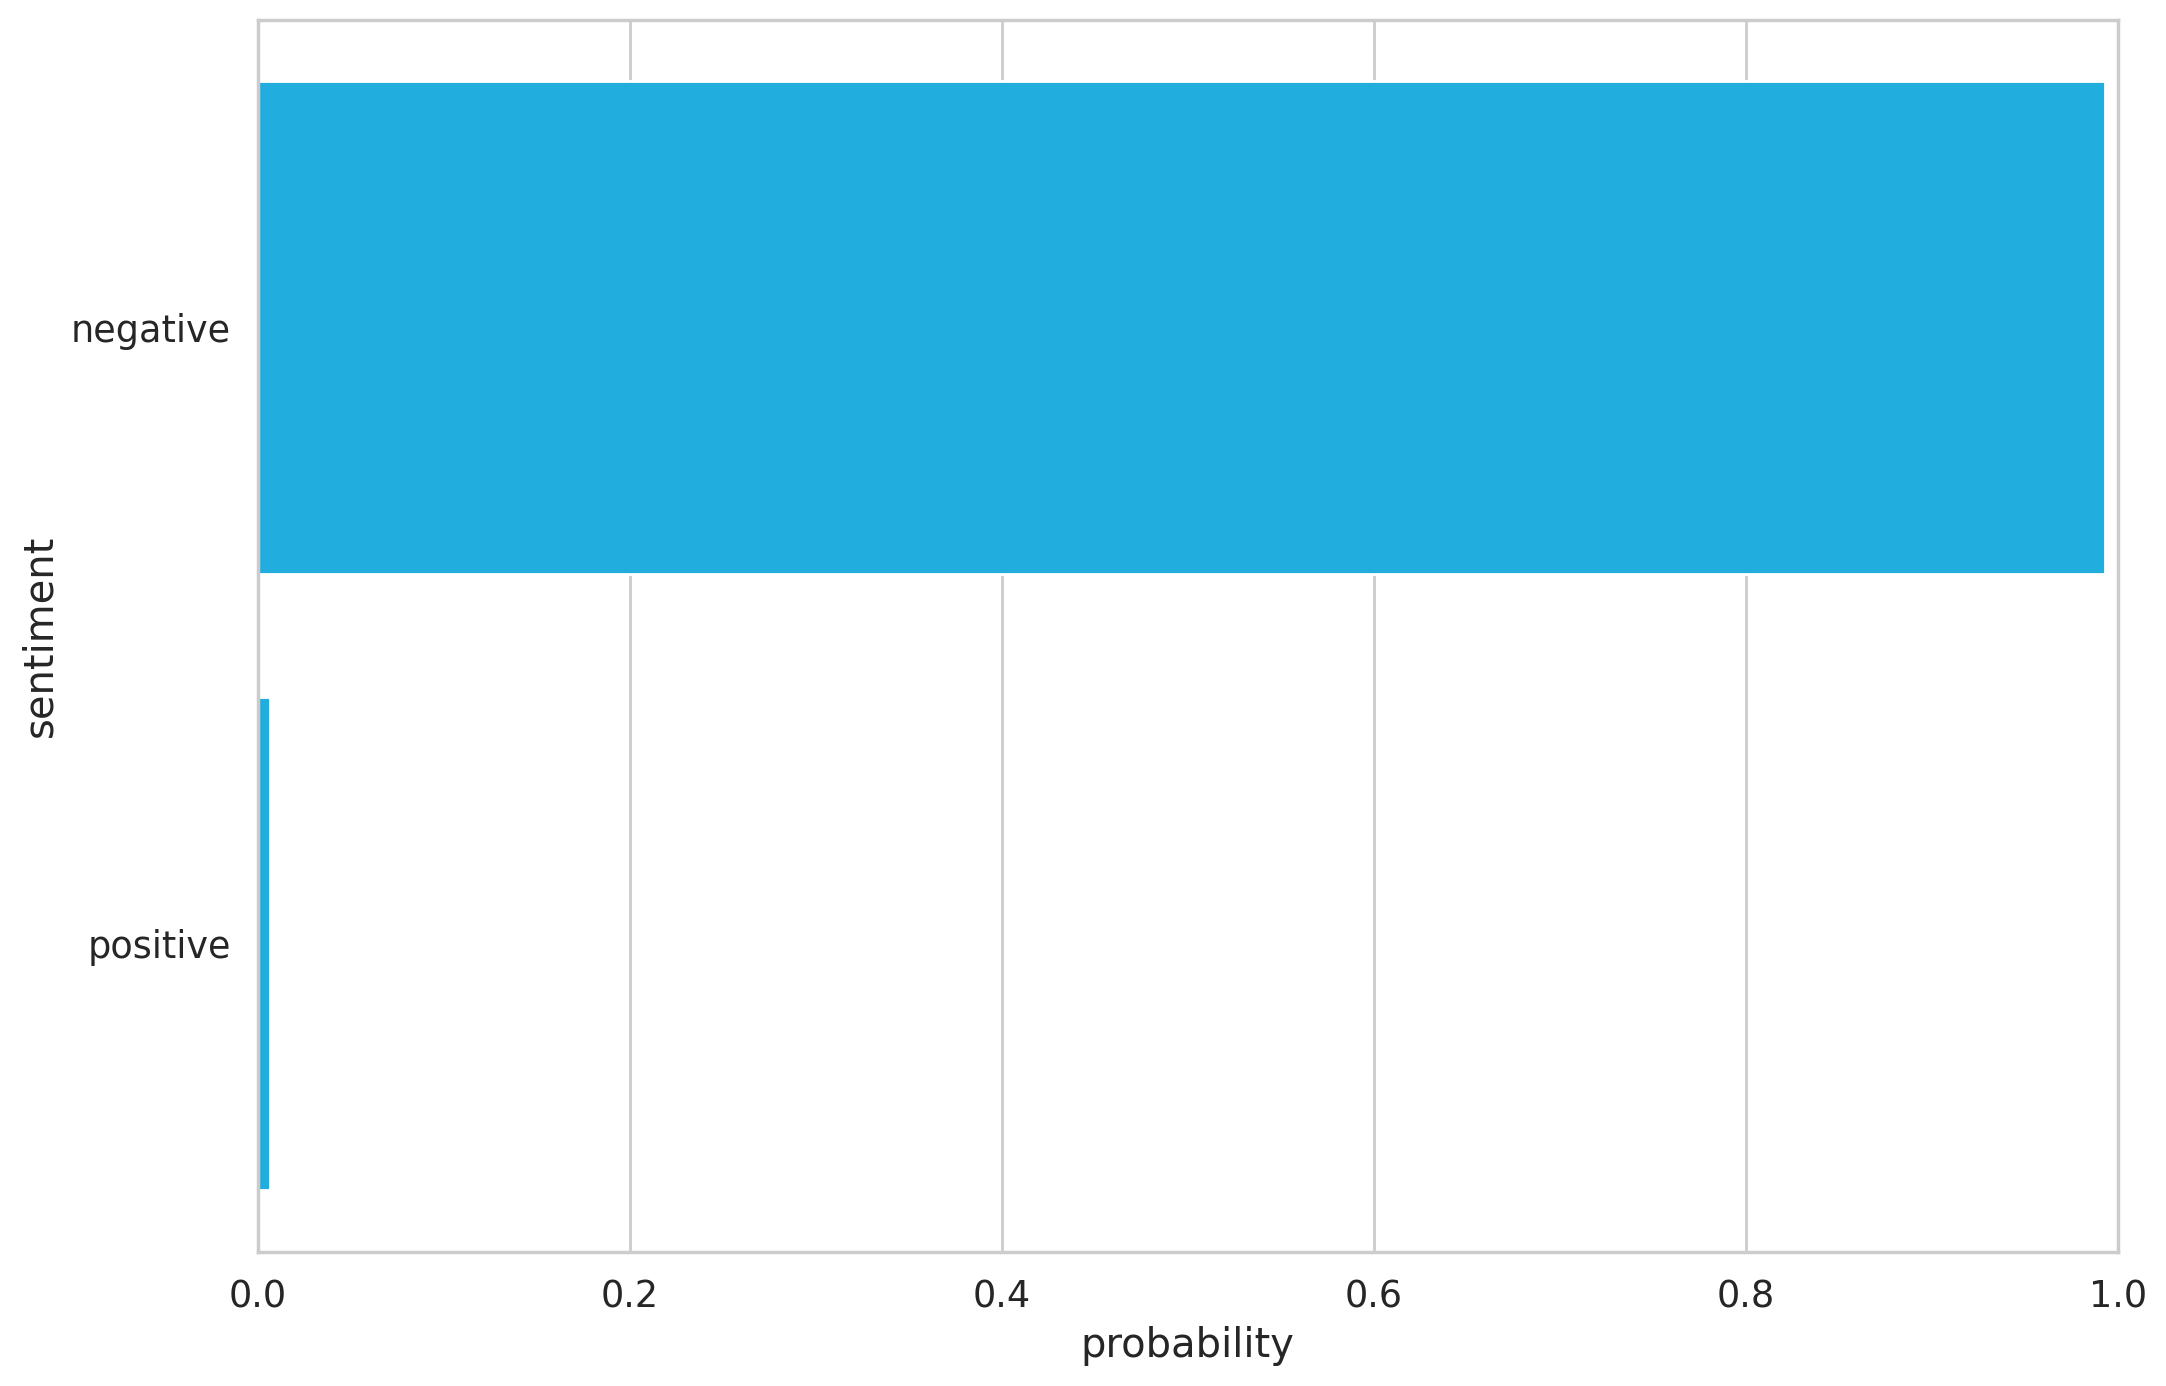

In [59]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Для данного примера использовался негативный обработанный отзыв из самого датасета с его реальной меткой, на графике видно, что она совпадает с меткой, предсказанной моделью.

In [60]:
# Прогнозирование необработанного отзыва

review_text = "I saw the film, but I can’t remember what it was about. Which means for me, an excellent student of easy virtue is an unworthy passer-by."

In [61]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [62]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I saw the film, but I can’t remember what it was about. Which means for me, an excellent student of easy virtue is an unworthy passer-by.
Sentiment  : negative


## Выводы:

- Соответствие между предсказаниями и реальностью: Модель эффективно распознает тональность текстов, что подтверждается корректной классификацией в демонстрационных примерах.

- Переносимость модели: Модели удалось адаптироваться к обработке нового текста, не встречавшегося в тренировочном наборе, что свидетельствует о её обобщающей способности.

In [63]:
torch.save(model.state_dict(), 'checkpoint_01.pth')

## Заключение

Модель BERT успешно справляется с задачей классификации эмоциональной окраски отзывов на фильмы с достаточно высокими показателями precision, recall и f1-score для обоих классов. Результаты свидетельствуют о том, что модель эффективна и может быть использована для анализа эмоциональной окраски текстовых данных.

Однако, всегда есть возможность для дальнейших улучшений, в частности, в уменьшении ошибок классификации и повышении точности определения эмоциональной окраски отзывов. Например, с помощью оптимизация гиперпараметров модели (например, learning rate, размеры батчей, количество эпох).